# Barrio Tortuga

#### Toy model of a neighborhood. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14
import os
import sys
import glob
import time
import warnings
import datetime 
print("Last updated on ", time.asctime())
import numpy as np
import pandas as pd
import matplotlib

Last updated on  Mon Apr 20 01:26:54 2020


In [2]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [3]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.visualization.TextVisualization import TextVisualization, TextGrid

In [6]:
from barrio_tortuga.barrio_tortuga.BarrioTortuga import Turtle, Patch, BarrioTortuga

In [17]:
from termcolor import colored

In [18]:
from enum import Enum
class PrtLvl(Enum):
    Mute     = 1
    Concise  = 2
    Detailed = 3
    Verbose  = 4

# Definition of Barrio Tortuga

### Madrid central district:

- Barrio tortuga is modelled as an idealisation of Madrid central district, a neighborhood (barrio) characterised by:

- Popultion: 131,928 people
- Area: 5.23 km2.
- Number of home: 63,622
- Thus number of people per home ~2

**Barrio Tortuga**

- Toroidal grid of 100 x 100 m2
- Made of square buildings of 30 x 30 m2.
- Between buildings run avenues of 20 m. 
- Thus the grid has 4 buildings, 2 avenues running longitudinal and 2 avenues running horizontal. 
- The inhabitable are is 0.6 x 0.6 = 0.36 of the total area 
- We assume that each building has 30 apartments. Each apartment has 30 m2.
- We can assume that each building is 10 stories high. 
- Thus the number of homes in the patch of the barrio is 30 x 4 = 120 homes.
- The number of turtles in barrio tortuga is 252 (same density that in Madrid center) and thus the number of turtles per home is also 2. 

In [19]:
people_madrid_center = 131928.
area_madrid_center = 5.23E+6           # in m2
people_per_m2_madrid_center = people_madrid_center / area_madrid_center
print(f' People/m2 in madrid center = {people_per_m2_madrid_center}')

 People/m2 in madrid center = 0.025225239005736137


In [20]:
area_barrio_tortuga = 1e+4   # in m2
turtles_barrio_tortuga = area_barrio_tortuga * people_per_m2_madrid_center
print(f' turtles in barrio tortuga = {turtles_barrio_tortuga}')

 turtles in barrio tortuga = 252.25239005736137


In [21]:
homes_in_barrio_tortuga = 120
turtes_per_home = turtles_barrio_tortuga / homes_in_barrio_tortuga
print(f' turtles per home barrio tortuga = {turtes_per_home}')

 turtles per home barrio tortuga = 2.1021032504780113


## Map for Barrio Tortuga

In [22]:
map_bt = np.genfromtxt("barrio-tortuga-map-dense.txt")

In [23]:
map_bt.shape

(100, 100)

In [39]:
def is_house(map_bt, x, y):
    if map_bt[x,y] == 1:
        return True
    else:
        return False


In [40]:
def print_house(map_bt):
    l,w = map_bt.shape
    H=''
    for x in range(l):
        H+='\n'
        for y in range(w):
            if is_house(map_bt, x, y):
                H +=colored('x','red')
            else:
                H +=colored('x','blue')
    H+='\n'
    return H
       

In [41]:
H = print_house(map_bt)

In [42]:
print(H)


xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [45]:
def set_doors():
    D = []
    for j in range (0,7):
        pdl = np.array((11, 5 + j * 15))
        pdr = np.array((15, 5 + j *15)) 
        #print(f' raw = {j}, pdl ={pdl}, pdr = {pdr}')
        R0DL = [pdl + i * np.array((15,0)) for i in range(0,6)]
        R0DR = [pdr + i * np.array((15,0)) for i in range(0,6)]
        #print('doors')
        #print(R0DL)
        #print(R0DR)
        for r in R0DL:
            D.append(r)
        for r in R0DR:
            D.append(r)
    return D

In [46]:
drs = set_doors()

In [47]:
print(drs)

[array([11,  5]), array([26,  5]), array([41,  5]), array([56,  5]), array([71,  5]), array([86,  5]), array([15,  5]), array([30,  5]), array([45,  5]), array([60,  5]), array([75,  5]), array([90,  5]), array([11, 20]), array([26, 20]), array([41, 20]), array([56, 20]), array([71, 20]), array([86, 20]), array([15, 20]), array([30, 20]), array([45, 20]), array([60, 20]), array([75, 20]), array([90, 20]), array([11, 35]), array([26, 35]), array([41, 35]), array([56, 35]), array([71, 35]), array([86, 35]), array([15, 35]), array([30, 35]), array([45, 35]), array([60, 35]), array([75, 35]), array([90, 35]), array([11, 50]), array([26, 50]), array([41, 50]), array([56, 50]), array([71, 50]), array([86, 50]), array([15, 50]), array([30, 50]), array([45, 50]), array([60, 50]), array([75, 50]), array([90, 50]), array([11, 65]), array([26, 65]), array([41, 65]), array([56, 65]), array([71, 65]), array([86, 65]), array([15, 65]), array([30, 65]), array([45, 65]), array([60, 65]), array([75, 65

# Grid properties


- Grid cells are indexed by [x][y], where [0][0] is assumed to be the bottom-left and [width-1][height-1] is the top-right. If a grid is
toroidal, the top and bottom, and left and right, edges wrap to each other

- Properties:
        - width, height: The grid's width and height.
        - torus: Boolean which determines whether to treat the grid as a torus.
        - grid: Internal list-of-lists which holds the grid cells themselves.

- Methods:
        - get_neighbors: Returns the objects surrounding a given cell.
        - get_neighborhood: Returns the cells surrounding a given cell.
        - get_cell_list_contents: Returns the contents of a list of cells
            ((x,y) tuples)
        - neighbor_iter: Iterates over position neightbors.
        - coord_iter: Returns coordinates as well as cell contents.
        - place_agent: Positions an agent on the grid, and set its pos variable.
        - move_agent: Moves an agent from its current position to a new position.
        - iter_neighborhood: Returns an iterator over cell coordinates that are in the neighborhood of a certain point.
        - torus_adj: Converts coordinate, handles torus looping.
        - out_of_bounds: Determines whether position is off the grid, returns the out of bounds coordinate.
        - iter_cell_list_contents: Returns an iterator of the contents of the cells identified in cell_list.
        - get_cell_list_contents: Returns a list of the contents of the cells identified in cell_list.
        - remove_agent: Removes an agent from the grid.
        - is_cell_empty: Returns a bool of the contents of a cell.


# Barrio Tortuga

In [66]:
def run_turtles(turtles, steps, map_file="barrio-tortuga-map-dense.txt"):
    """Run turtles in Barrio Tortuga"""
    
    print(f" Running Barrio Tortuga with {turtles}  turtles, for {steps} steps.")
    bt = BarrioTortuga(map_file=map_file, turtles=turtles, nd=1, prtl=PrtLvl.Concise)
    
    for i in range(steps):
        if i%100 == 0:
            print(f' step {i}')
        bt.step()
    return bt.datacollector.get_model_vars_dataframe()

In [67]:
dft = run_turtles(turtles=25, steps=500)

 Running Barrio Tortuga with 25  turtles, for 500 steps.
loaded barrio tortuga map with dimensions ->(100, 100)
 raw = 0, pdl =[10  5], pdr = [14  5]
doors
[array([10,  5]), array([25,  5]), array([40,  5]), array([55,  5]), array([70,  5]), array([85,  5])]
[array([14,  5]), array([29,  5]), array([44,  5]), array([59,  5]), array([74,  5]), array([89,  5])]
 raw = 1, pdl =[10 20], pdr = [14 20]
doors
[array([10, 20]), array([25, 20]), array([40, 20]), array([55, 20]), array([70, 20]), array([85, 20])]
[array([14, 20]), array([29, 20]), array([44, 20]), array([59, 20]), array([74, 20]), array([89, 20])]
 raw = 2, pdl =[10 35], pdr = [14 35]
doors
[array([10, 35]), array([25, 35]), array([40, 35]), array([55, 35]), array([70, 35]), array([85, 35])]
[array([14, 35]), array([29, 35]), array([44, 35]), array([59, 35]), array([74, 35]), array([89, 35])]
 raw = 3, pdl =[10 50], pdr = [14 50]
doors
[array([10, 50]), array([25, 50]), array([40, 50]), array([55, 50]), array([70, 50]), array([8

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116450c10>]],
      dtype=object)

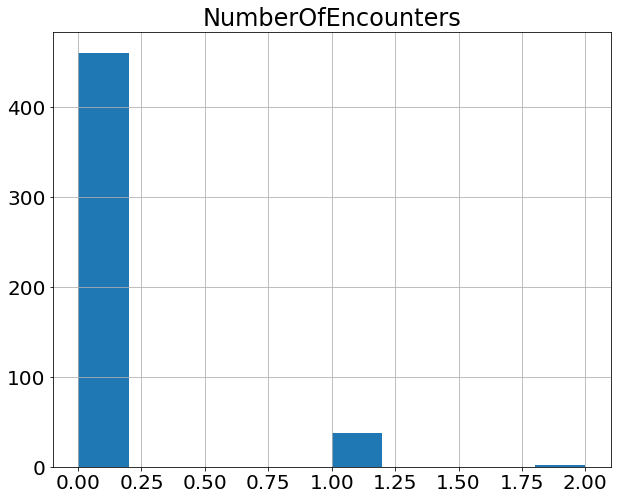

In [68]:
dft.hist("NumberOfEncounters")

## BarrioTortugaViz

In [11]:
class BarrioTortugaViz(TextVisualization):
    '''
    ASCII Visualization of Barrio Tortuga
    Each cell is displayed as the number of turtles currently in that cell.
    '''

    def __init__(self, model):
        '''
        Create a new visualization for the model instance.

        args:
            model: An instance of a WalkerWorld model.
        '''
        self.model = model
        grid_viz = TextGrid(self.model.grid, None)
        grid_viz.converter = lambda x: str(len(x))
        self.elements = [grid_viz]


### Test model using a simple text visulisation

In [12]:
def run_turtles(w=10, h=10, na=50, steps=2, vis_steps = 3):
    """Run turtles in Barrio Tortuga"""
    
    print(f"Testing {w}x{h} world, with {na} random turtles, for {steps} steps.")
    
    model = BarrioTortuga(w, h, na)
    viz = BarrioTortugaViz(model)
    vs = 0
    for i in range(steps):
        if vs < vis_steps:
            vs+=1
            print("Step:", str(i))
            viz.step()
        else:
            if i%10 == 0:
                print("Step:", str(i))
            model.step()
    return model.datacollector.get_model_vars_dataframe()

In [13]:
dft = run_turtles(w=100, h=100, na=1000, steps=100, vis_steps = 1)

Testing 100x100 world, with 1000 random turtles, for 100 steps.
Step: 0
0000000000000000010000001000000100000000001000000000000000100100000000010000000020000100011000000000
0000000000000010000000000000001000000000000000100000000010001001000000000000000000010010000000001000
0000000001000000000000000000010000010000001000000000000000000002000000000001000000000001000000000000
0000000000000000000001001000010000000000010000000000000100000010000000000000000000000000000000001000
0100010000010100001010000100000000000010000000000000000000000000100000001010001010010001000100000000
0000010101000010000010001000001101000000000000000020001010000000000000000000000000000200100000011000
1000002000000100000000000000100100000000000000000000000000001001000000000000000000000000100000011101
0010000000100010000000000101000000000000000000000010000001000000000000010000000010000000100010000000
0000000000010000000000000000010010000000010000010000001000000000001000000000000000000110000010000010
0000000000000000201

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b39aa50>]],
      dtype=object)

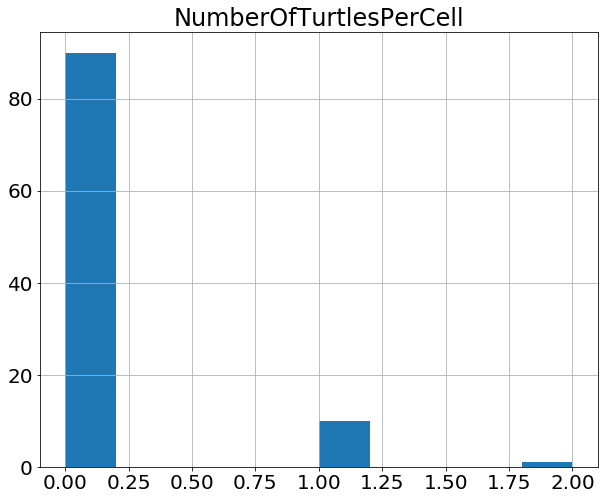

In [14]:
dft.hist("NumberOfTurtlesPerCell")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ba671d0>]],
      dtype=object)

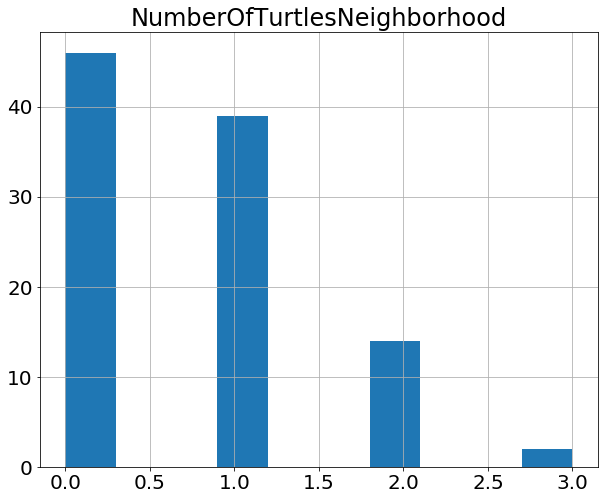

In [15]:
dft.hist("NumberOfTurtlesNeighborhood")